# Use bagging gradient boost + lasso + ridge to predict house prices



# This notebook is inspired by:
https://www.kaggle.com/apapiu/regularized-linear-models  by  Alexandru Papiu (@apapiu, GitHub)

https://www.kaggle.com/skyjiao/xgboost-bagging

## I used ensemble method that combines 3 different models:
1. bagging xgboost
2. lasso
3. ridge
### The outputs in this kernel receive the following scores:
    1. ensemble_1: 0.11929
    2. ensemble_2: 0.11937
    3. ensemble_3: 0.12003
    4. ensemble_4: 0.12012

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.ensemble import BaggingRegressor
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
# Any results you write to the current directory are saved as output.


#Customizations
sns.set() #matplotlib defaults

#Any tweaks that normally go in .matplotlibrc, etc should explicitly go here
plt.rcParams['figure.figsize'] = (12,8)
%config InlineBackend.figure_format = 'retina'


['train.csv', 'data_description.txt', 'test.csv', 'sample_submission.csv']


In [2]:
#Read the data
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
train.tail()
#concatenate train and test
all_data = pd.concat([train.loc[:,'MSSubClass':'SaleCondition'],test.loc[:,'MSSubClass':'SaleCondition']])

## 2. Data Prepocessing:
### We only do the following simple preprocessing:
1. separate numerical , categorical features with dtypes
2. use one hot encoding for categorical
3. impute NaN data with their means
4. log1p transform highly skewed features (threshold =.75) and the target y
5. normalize the features to N(0,1) ,


### 2.1 Some function definitions for preprocessing

In [3]:
from scipy.stats import skew

def num_cat_separate(df):
    """
    seperate features into numerica and categorical features based on dtypes
    return: df of column names
    -------
    df: DataFrame, contains columns of numeric and categorical data
    """
    nuemric_features = df.dtypes[df.dtypes !='object']
    categorical_features = all_data.dtypes[df.dtypes =='object']
    return nuemric_features, categorical_features

def remove_skewness(df,features_to_check ,threshold=None):
    """
    log1p transform the skewed featrues if the skewness is greater than sk_threshold
    """
    df_copy = df.copy()
    transformed_feats = df[features_to_check].apply(lambda x: skew(x.dropna()))
    if threshold is not None:
        transformed_feats = transformed_feats[transformed_feats > threshold]
    transformed_feats = transformed_feats.index
    
    print(f'The features that are log1p transformed, with threshold = {threshold}: {transformed_feats}')
    df_copy[transformed_feats] = np.log1p(df[transformed_feats])
    return df_copy
    

def normalize(df):
    df_stats = df.describe()
    df_stats = df_stats.transpose()
    normed_df = (df-df_stats.loc[:,'mean']) /df_stats.loc[:,'std']
    return normed_df
# def error(actual, hat):
#     return np.sqrt(np.sum(np.square(np.log(actual)-np.log(hat)))/len(actual))
def rmse(actual, hat):
    return np.sqrt(np.sum(np.square(actual-hat))/len(actual))


def rmse_cv(model,X_train,y,scoring ='neg_mean_squared_error',  **kwargs):
    rmse = np.sqrt(-cross_val_score(model, X_train,y,scoring= scoring,**kwargs))
    return rmse

### 2.2 Apply the preprocessing 1-5

In [4]:
#separate numeric, categorical features
numeric_features, categorical_features = num_cat_separate(all_data)

#set categorical data into dummy
all_data = pd.get_dummies(all_data)

#log transform to remove skewness
all_data = remove_skewness(all_data, numeric_features.index,threshold=.75)

#fill missing data with their mean
all_data = all_data.fillna(all_data.mean())

#prepare data for learning
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y=train.SalePrice


y_log = np.log1p(y)

#normalize the data for lasso and ridge
normed_all_data = normalize(all_data)
normed_X_train = normed_all_data[:train.shape[0]]
normed_X_test = normed_all_data[train.shape[0]:]


The features that are log1p transformed, with threshold = 0.75: Index(['MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')


### 2.3 train/validation split

In [5]:
from sklearn.model_selection import train_test_split
train_X, valid_X, train_y, valid_y = train_test_split(X_train,y_log, test_size =.3, random_state=0)

# 3. Models

In [6]:
from sklearn.metrics import mean_squared_error
def rmse(y_actual,y_pred):
    return np.sqrt(mean_squared_error(y_actual,y_pred))

## 3.1 Lasso and Ridge

### 3.1.1 Ridge

In [7]:
from sklearn.linear_model import Ridge, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score


In [8]:
alpha= 10.64636132589743 #pre-determined alpha with cv that is not shown
alphas = np.linspace(.9*alpha, 1.1*alpha,20)
model_Ridge = RidgeCV(alphas=alphas, cv=4 )
model_Ridge.fit(X_train,y_log)
y_log_hat = model_Ridge.predict(X_train)
print('The error of Ridege on the training set is:',rmse(y_log,y_log_hat))
print('optimized Ridge alpha is', model_Ridge.alpha_)


The error of Ridege on the training set is: 0.10537996353392427
optimized Ridge alpha is 9.581725193307689


Text(0.5, 1.0, '20 most important coefficients in the Ridge Model')

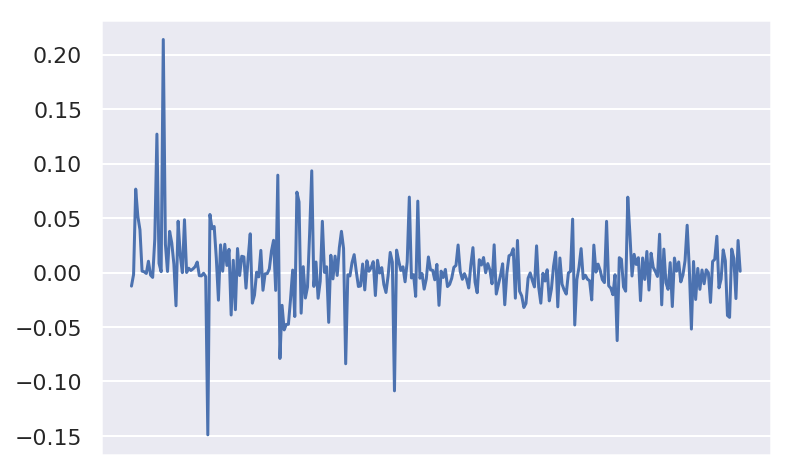

<Figure size 432x288 with 0 Axes>

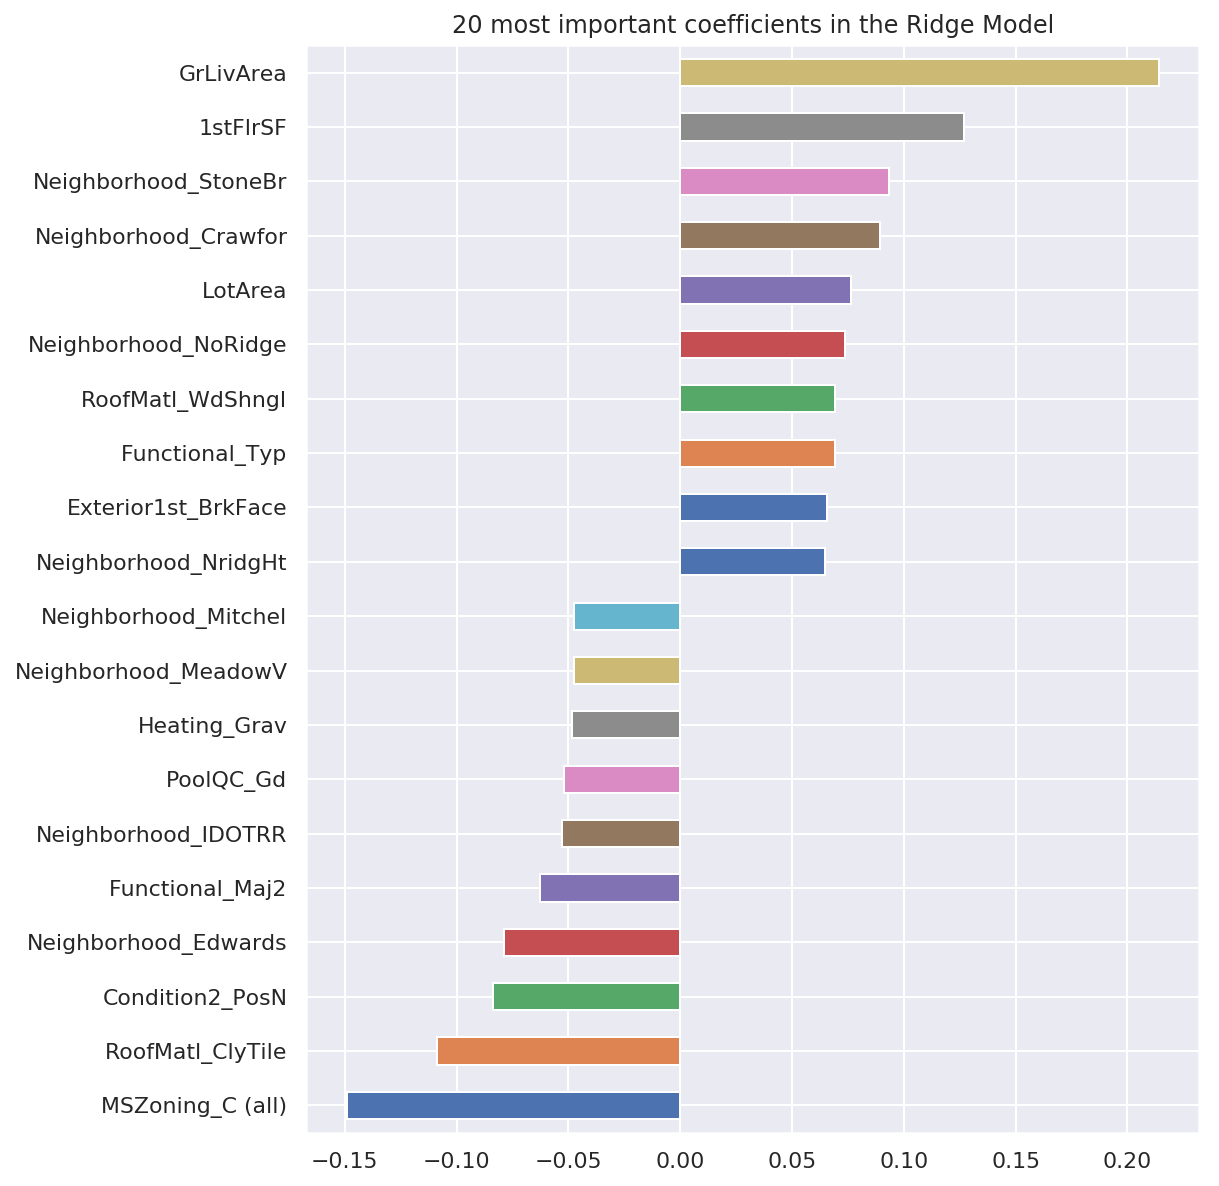

In [9]:
Ridge_coef = pd.Series(model_Ridge.coef_, index = X_train.columns)
plt.plot(Ridge_coef)
plt.xticks([])

imp_coef = pd.concat([Ridge_coef.sort_values().head(10),
                     Ridge_coef.sort_values().tail(10)])

plt.figure()
plt.figure(figsize=(8.0, 10.0))
imp_coef.plot(kind = "barh")
plt.title("20 most important coefficients in the Ridge Model")

### 3.1.2 LassoCV

[1.00000000e-05 1.27427499e-05 1.62377674e-05 2.06913808e-05
 2.63665090e-05 3.35981829e-05 4.28133240e-05 5.45559478e-05
 6.95192796e-05 8.85866790e-05 1.12883789e-04 1.43844989e-04
 1.83298071e-04 2.33572147e-04 2.97635144e-04 3.79269019e-04
 4.83293024e-04 6.15848211e-04 7.84759970e-04 1.00000000e-03]
alpha =  0.0004832930238571752 
 rmse =  0.12256729689278408


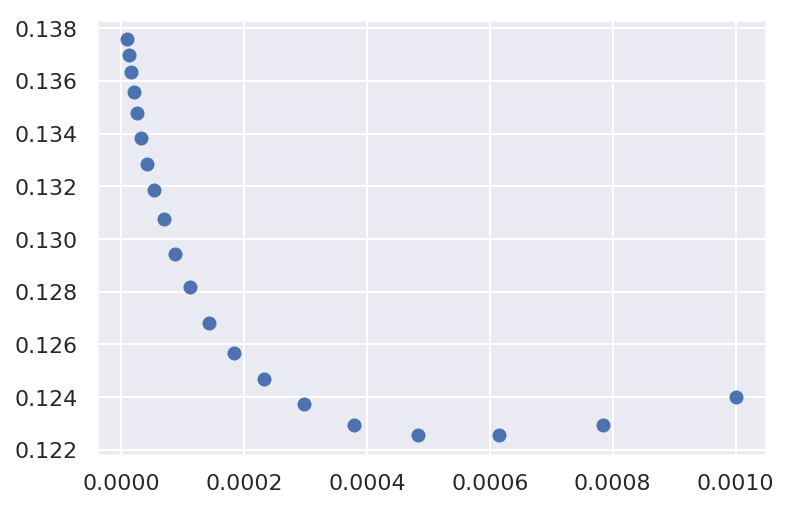

In [10]:
alphas = np.logspace(-5,-3, num=20)
print(alphas)

cv_lasso = [ rmse_cv(Lasso(alpha = alpha,max_iter=50000), X_train,y_log,cv=5).mean() for alpha in alphas]
cv = pd.Series(cv_lasso, index= alphas)
plt.figure(figsize=(6,4))
plt.plot(cv,'bo')
minimum = cv[cv==cv.min()]
alpha = minimum.index.values[0]
print('alpha = ',alpha,'\n rmse = ',minimum.values[0])

In [11]:
#fine tune the alpha with LassoCV

alphas =np.linspace(.75*alpha,1.25*alpha,20)

model_LassoCV = LassoCV(alphas=alphas, max_iter=10000, cv=4 )
model_LassoCV = model_LassoCV.fit(X_train,y_log)
rmse_cv(model_LassoCV,X_train=X_train,y=y_log,cv=5).mean()

0.12257909800610196

In [12]:
alpha = cv[cv==cv.min()].index.values[0]
print('a coarse search of penalization strength, alpha, is:',alpha)

a coarse search of penalization strength, alpha, is: 0.0004832930238571752


In [13]:
#fine tune the alpha for LassoCV
alphas =np.linspace(.75*alpha,1.25*alpha,10)

model_LassoCV = LassoCV(alphas=alphas, max_iter=50000, cv=8 )
model_LassoCV = model_LassoCV.fit(X_train,y_log)

alpha = model_LassoCV.alpha_

y_log_pred = model_LassoCV.predict(X_train)
print('alpha:',alpha,'\n cv rmse score:',rmse(y_log_pred, y_log))

alpha: 0.00044301860520241064 
 cv rmse score: 0.10361987356743488


In [14]:
lasso_submission = model_LassoCV.predict(X_test)
submission = pd.read_csv('../input/sample_submission.csv')
submission.SalePrice = np.expm1(lasso_submission)
submission.to_csv('lasso_submission.csv',index=False)

## 3.2 Bagging gradient boost with XGBRegressor 

## bagging 50 different trees

In [15]:
from xgboost import XGBRegressor #import a the sklearn wrapped xgboost regressor


In [16]:
num_round=530; #num_round was pre-determined with cv, not shown here
n_trees = 40;
xgb_regr = XGBRegressor(max_depth= 3, learning_rate= .1 ,n_estimators= num_round, colsample_bytree=.8 ) 
#colsample_bytree is used to sample the columns used to construct each tree, 
#add randomness to the model with colsample_bytree <1

bagging_xgb = BaggingRegressor(xgb_regr,max_samples=.8, n_estimators=n_trees, n_jobs=-1) 
#set n_of xgb estimators to 40, and n_jobs =-1 to use all cpu for paralellism.

print(xgb_regr)
print(bagging_xgb)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=530, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)
BaggingRegressor(base_estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=530, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=40, n_jobs=-1, oob_score=Fals

In [17]:
bagging_xgb.fit(train_X,train_y)

BaggingRegressor(base_estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=530, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=40, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [18]:

print('training bagging R^2 score:', bagging_xgb.score(train_X, train_y))
print('validation bagging R^2 score:', bagging_xgb.score(valid_X, valid_y))


training bagging R^2 score: 0.9735023080262364
validation bagging R^2 score: 0.9082083049463487


In [19]:
print('rmse score of training set:',rmse(train_y, bagging_xgb.predict(train_X)))
print('rmse score of validating set:',rmse(valid_y, bagging_xgb.predict(valid_X)))

rmse score of training set: 0.06542882233136876
rmse score of validating set: 0.11909101579433681


## re-train with the entire training set and submit

In [20]:
bagging_xgb.fit(X_train,y_log) #X_train, y_log is the entire training dataset


BaggingRegressor(base_estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=530, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=0.8, n_estimators=40, n_jobs=-1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [21]:
print('training bagging R^2 score:', bagging_xgb.score(X_train, y_log))
print('rmse score of training set:',rmse(y_log, bagging_xgb.predict(X_train)))

training bagging R^2 score: 0.9730591891252035
rmse score of training set: 0.06554177293262133


In [22]:
bagging_xgb_all_y_pred = bagging_xgb.predict(X_test)
submission = pd.read_csv('../input/sample_submission.csv')
submission.SalePrice = np.expm1(bagging_xgb_all_y_pred)
submission.to_csv('bagging_40_xgb.csv',index=False)

# Submit an ensemble of bagging gradient boost, lasso and ridge

In [23]:
Lasso_pred = model_LassoCV.predict(X_test)
bagging_pred = bagging_xgb.predict(X_test)
Ridge_pred = model_Ridge.predict(X_test)

y_log_preds = [Lasso_pred,Ridge_pred,bagging_pred]

w1=.5;
w2=.25;
w3=1-w1-w2
weights = [w1,w2,w3]

# ensemble = np.exp1m(np.dot(y_log_preds,weights))

In [24]:
submission = pd.read_csv('../input/sample_submission.csv')

ensemble_1 = [w*y for w,y in zip(weights, y_log_preds)]
ensemble_1 = sum(ensemble_1)

submission.SalePrice = np.expm1(ensemble_1)
submission.to_csv('ensemble_1.csv',index=False)


ensemble_2 = np.expm1(y_log_preds)
ensemble_2 = sum([w*y for w,y in zip(weights,ensemble_2)])
submission.SalePrice = ensemble_2
submission.to_csv('ensemble_2.csv',index=False)
# submission.SalePrice = np.dot(np.expm1(y_log_preds),weights)
# submission.to_csv('ensemble_2.csv',index=False)

In [25]:
weights = [.5,0,.5]
ensemble_3 = [w*y for w,y in zip(weights, y_log_preds)]
ensemble_3 = sum(ensemble_3)
submission.SalePrice = np.expm1(ensemble_3)
submission.to_csv('ensemble_3.csv',index=False)

ensemble_4 = np.expm1(y_log_preds)
ensemble_4 = sum([w*y for w,y in zip(weights,ensemble_4)])
submission.SalePrice = ensemble_4
submission.to_csv('ensemble_4.csv',index=False)